In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import numpy as np
import re
import os
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVR
from sklearn import preprocessing
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from numpy import array
from numpy import hstack
from statsmodels.graphics.gofplots import qqplot
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib
%matplotlib inline

How imbalanced are your training sets for Ontario and Quebec? <br>
#### What are the shapes of training and test sets? 
Ans: x_train (2394, 1, 69) <br>
x_test (612, 1, 69)
#### Are you using the same normalization for training and testing?
Ans: yes
#### Did you use any l1 or l2 regularization?
Ans: No
#### Can you copy here your train/test error and accuracy for ON and QC? <br>
##### Label: Cumulative_cases
HR |  |  | 2406 | 2416 | 2413 | 2414 | 2415
--- | --- | --- | --- | --- | --- | --- | ---
HR | Dim | ACC | montréal | montérégie | laval | lanaudière | laurentides
Train | 0.8 | ACC | 0.99242  | 1.0               | 1.0   | 1.0              | 1.0
Test | 0.2 | ACC | 1.0           | 1.0               | 1.0   | 1.0              | 1.0

#### In the ON notebook in cells out[19] and out[27], the val_accuracy is constant 1. Is that expected?
Ans: Train Data: Jan/25 - May/29, <br>
Test Data: May/30 - June/29
#### Are you training to do 1-day-ahead prediction based on 5-day-prior data (lag features)? 
Ans: yes

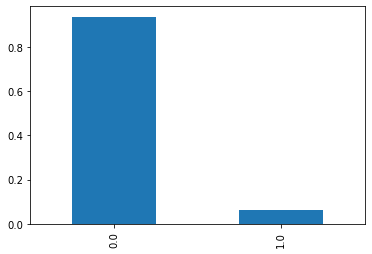

In [26]:
plt.figure()
df_merge_model.cumulative_cases_la.value_counts(normalize=True).plot(kind='bar')

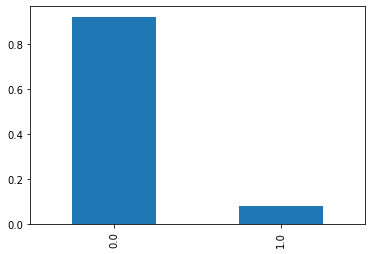

In [37]:
# label distribution of train dataset
plt.figure()
df_train_label[0].value_counts(normalize=True).plot(kind='bar')

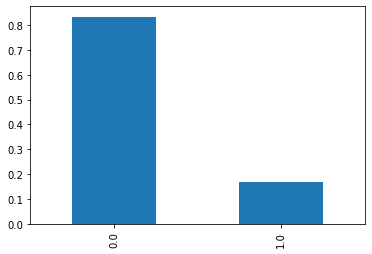

In [38]:
# label distribution of test dataset
plt.figure()
df_test_label[0].value_counts(normalize=True).plot(kind='bar')

### Quebec 18 HRs
### Label: Cumulative_deaths test split 0.2

 

HR |  |  | 2406 | 2416 | 2413 | 2414 | 2415
--- | --- | --- | --- | --- | --- | --- | ---
HR | Dim | ACC | montréal | montérégie | laval       | lanaudière | laurentides
Train | 0.8 | ACC | 0.97727  | 1.0               | 0.95455 | 0.84091      | 1.0
Test | 0.2 | ACC | 1.0           | 0.58824       | 1.0          | 1.0             | 1.0 


### Label: Cumulative_cases
HR |  |  | 2406 | 2416 | 2413 | 2414 | 2415
--- | --- | --- | --- | --- | --- | --- | ---
HR | Dim | ACC | montréal | montérégie | laval | lanaudière | laurentides
Train | 0.8 | ACC | 0.99242  | 1.0               | 1.0   | 1.0              | 1.0
Test | 0.2 | ACC | 1.0           | 1.0               | 1.0   | 1.0              | 1.0

## Connect to DB

In [33]:
## Run
## change label: df_merge_model = label('cumulative_cases')
## process data
conn = sqlite3.connect('../../data/hubs.db')
df_mob = pd.read_sql_query("SELECT * from Mobility_HR_V", conn)
df_mob_sort = df_mob.sort_values(by=['HR_UID','DATE'])
df_health = pd.read_sql_query("SELECT * from Health_Indicators_ODHF", conn)
df_health1 = df_health[['HR_UID','Population_density', 'ambulatory','hospitals','nursing_residential', 'Perceived_health_good', 'Perceived_health_poor']]
mob_health = pd.merge(df_mob, df_health1, how='left', on=['HR_UID'])
df_COVID = pd.read_sql_query("SELECT * from Covid19", conn)
# total cols of 2 dataframe merged
new = df_COVID['HR_UID'].str.split(".", n = 1, expand = True) 
df_COVID['HR_UID']= new[0]
pd_merge = pd.merge(mob_health, df_COVID, how='right', left_on=['DATE', 'HR_UID'], right_on=['report_date', 'HR_UID'])
# mob_health date '2020-07-05'
max_date = mob_health['DATE'].max()
max_date1 = df_COVID['report_date'].max()
if max_date<max_date1:
    max_dt = max_date
else:
    max_dt= max_date1
pd_merge_new = pd_merge.loc[(pd_merge['DATE']>='2020-01-25') & (pd_merge['DATE']<=max_dt)]
# dropping duplicte values on same HR_UID and Date
pd_merge_new.drop_duplicates(subset =["HR_UID", "DATE"], inplace = True) 
# add label to df
df_risk_label = pd.read_sql_query("SELECT * from HIGH_RISK_6", conn)
df_risk_label_la = df_risk_label.rename(columns={"cases": "cases_la", "cumulative_cases": "cumulative_cases_la",
                             "deaths":"deaths_la", "cumulative_deaths":"cumulative_deaths_la"})
pd_merge_label = pd.merge(pd_merge_new, df_risk_label_la, on=['report_date', 'HR_UID'], how='left')
# minmax scaler
scaler = MinMaxScaler()
# minmax scaler
scaler1 = MinMaxScaler()
# add and remove cumulative_deaths, cumulative_cases
def label(label):
    lst = ['Md_PD', 'Mrr_PD',
        'Mgp_PD', 'Mp_PD', 'Mt_PD', 'Mw_PD', 'Mr_PD', 'M_PD', 'Md_MD',
        'Mrr_MD', 'Mgp_MD', 'Mp_MD', 'Mt_MD', 'Mw_MD', 'Mr_MD', 'M_MD','Md_RP', 'Mrr_RP',
       'Mgp_RP', 'Mp_RP', 'Mt_RP', 'Mw_RP', 'Mr_RP', 'M_RP', 'Md_MP', 'Mrr_MP',
       'Mgp_MP', 'Mp_MP', 'Mt_MP', 'Mw_MP', 'Mr_MP', 'M_MP','cases', 'cumulative_cases', 'deaths',
       'cumulative_deaths', 'Population_density','ambulatory','hospitals','nursing_residential']
#     lst.remove(label)
    data = pd_merge_label[lst]

    df_label = pd_merge_label[[label]]
    data_scale = scaler.fit_transform(data)
#     data_scale1 = scaler1.fit_transform(data1)
    df_data_scale = pd.DataFrame(data=data_scale,columns=lst)
#     df_data_scale1 = pd.DataFrame(data=data_scale1,columns=[label])
    col_lst = list(set(pd_merge_label.columns.tolist()) - set(df_data_scale.columns.tolist())- set(df_label.columns.tolist()))
    col_lst.append('PRUID_x')
    pd_feature = pd_merge_label[col_lst]
    pd_feature.reset_index(inplace=True)
    df_merge_model = pd.concat([pd_feature, df_data_scale, df_label], axis=1)
    return df_merge_model

# Change the label cumulative_cases_la
df_merge_model = label('cumulative_cases_la')
df_merge_model.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


index        DATE  Perceived_health_good  cumulative_deaths_la PRUID_x  \
0      0  2020-01-25                  0.577                   0.0      35   
1      1  2020-01-26                  0.577                   0.0      35   
2      2  2020-01-27                  0.577                   0.0      35   
3      3  2020-01-28                  0.577                   0.0      35   
4      4  2020-01-29                  0.577                   0.0      35   

  HR_UID  deaths_la                    HR_NAME  cases_la  \
0   3553        0.0  Peel Regional Health Unit       0.0   
1   3553        0.0  Peel Regional Health Unit       0.0   
2   3553        0.0  Peel Regional Health Unit       0.0   
3   3553        0.0  Peel Regional Health Unit       0.0   
4   3553        0.0  Peel Regional Health Unit       0.0   

   Perceived_health_poor  ...      M_MP cases cumulative_cases deaths  \
0                  0.106  ...  0.621158   0.0              0.0    0.0   
1                  0.106  ...  0.434065   0.0              0.0    0.0   
2                  0.106  ...  0.511856   0.0              0.0    0.0   
3                  0.106  ...  0.550283   0.0              0.0    0.0   
4                  0.106  ...  0.568742   0.0              0.0    0.0   

  cumulative_deaths  Population_density  ambulatory  hospitals  \
0               0.0            0.255652         1.0   0.714286   
1               0.0            0.255652         1.0   0.714286   
2               0.0            0.255652         1.0   0.714286   
3               0.0            0.255652         1.0   0.714286   
4               0.0            0.255652         1.0   0.714286   

   nursing_residential  cumulative_cases_la  
0                  1.0                  0.0  
1                  1.0                  0.0  
2                  1.0                  0.0  
3                  1.0                  0.0  
4                  1.0                  0.0  

[5 rows x 56 columns]

## Model Input for Multiple Input Series
-  first dimension is the number of samples
-  second dimension is the number of time steps per sample
-  the last dimension specifies the number of parallel time series or the number of variables

## Multivariate model
- label: Cum_deaths
    - lag features: 5 days
- label: Cum_cases
    - lag features: 5 days
    
- ON
    - 34 pandemic hubs
- approach
    - first
    - get independent HR df and train test split by 0.8 and 0.2, (by time-series factor), take time into account
    - concat array for X_train, and X_test

In [34]:
## Run
## change the label df_label = df_hr[['cumulative_cases_x']]
## change time_lag features
# # shift the value upward
df_merge_model['report_date'] = pd.to_datetime(df_merge_model['report_date'])
# df1 = df.set_index('DATE')
df_new = df_merge_model[['HR_UID', 'report_date','cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP', 'report_date']]

def shift_df(lst, lag_date):
    for date in range(0, lag_date):
        lag_date_run = date+1
        for a in lst:
            col_name = a + str('_-'+str(lag_date_run))
            val = -lag_date_run
            df_new[col_name] = df_new.groupby(['HR_UID'])[a].shift(val)
    return df_new

df_new1 = shift_df(['HR_UID','cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP'],5)
# remove null row
df_new1.dropna(inplace=True)
# drop duplicated columns
df_new2 = df_new1.loc[:,~df_new1.columns.duplicated()]

## Merge df back with health indicator
df_new3 = pd.merge(df_merge_model, df_new2, how='left', on=['HR_UID','report_date'])
# remove null row
df_new3.dropna(inplace=True)
# drop duplicated columns
df_new4 = df_new3.loc[:,~df_new3.columns.duplicated()]
df_on = df_new4.loc[df_new4['PRUID_x']==str(24)]
df_dum_HR = pd.get_dummies(df_on.HR_UID, prefix='HR_UID')
df_on_dum = pd.concat([df_on, df_dum_HR], axis=1)

# select one hr
def df_filter(hr, case, lag_date):
    df_hr = df_on_dum.loc[df_on_dum['HR_UID']==str(hr)]
    # list for input lagged features
    lst = ['cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP']
    col_lst = []
    for date in range(0, lag_date):
        lag_date_run = date+1
        for a in lst:
            col_name = a + str('_-'+str(lag_date_run))
            col_lst.append(col_name)
            
    lst1 = ['Mt_RP_x', 'Mt_MP_x', 'Mw_MD_x', 'Mgp_RP_x', 'Population_density','ambulatory',
               'hospitals','nursing_residential', 'Perceived_health_good', 'Perceived_health_poor']
    col_lst+=lst1
    col_lst+=df_dum_HR.columns.tolist()
    
    if case:
        col_lst.append('cases_x')
    df_feature = df_hr[col_lst]
    df_label = df_hr[['cumulative_cases_la']]
    # drop duplicated columns
    df_hr1 = df_hr.loc[:,~df_hr.columns.duplicated()]
   
    return df_feature, df_label, df_hr1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [35]:
## Run
X_train_lst = []
X_test_lst = []
y_train_lst = []
y_test_lst = []

for hr in df_on['HR_UID'].unique().tolist():
    
    df_feature, df_label, df_hr1 = df_filter(hr, True,5)
    X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.2, random_state=42, shuffle=False)
    
    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    X_train_lst.append(X_train)
    X_test_lst.append(X_test)
    y_train_lst.append(y_train)
    y_test_lst.append(y_test)
    # X_train shape ((138, 68))

X_train = np.concatenate(X_train_lst, axis=0)
X_test = np.concatenate(X_test_lst, axis=0)
y_train = np.concatenate(y_train_lst, axis=0)
y_test = np.concatenate(y_test_lst, axis=0)
Y_train = y_train.reshape(-1,)
Y_test = y_test.reshape(-1,)


In [36]:
df_train_label = pd.DataFrame(y_train)
df_test_label = pd.DataFrame(y_test)
df_test_label.head()

0
0  0.0
1  0.0
2  0.0
3  0.0
4  0.0

In [30]:
## Run
n_sample = 1
n_step = X_train.shape[0]
n_features = X_train.shape[-1]
x_train = X_train.reshape(n_step, -1,n_features)
x_test = X_test.reshape(X_test.shape[0], -1,X_test.shape[-1])

x_train.shape
# (108, 1,  11)

(2394, 1, 69)

In [31]:
x_test.shape

(612, 1, 69)

In [8]:
def lstm(x_train, Y_train, X_test, y_test, n_step, n_features, input_LSTM):
    model = Sequential()
    model.add(LSTM(input_LSTM, activation='relu', input_shape=(n_step, n_features)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    # fit model
    history =model.fit(x_train, Y_train, epochs=20, verbose=2, validation_data=(X_test, y_test))
    return history, model

In [9]:
def lstm_2layer(x_train, Y_train, X_test, y_test, n_step, n_features, input_LSTM):
    model = Sequential()
    model.add(LSTM(input_LSTM, activation='relu', input_shape=(n_step, n_features), return_sequences=True))
    model.add(LSTM(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    # fit model
    history =model.fit(x_train, Y_train, epochs=20, verbose=2, validation_data=(X_test, y_test))
    return history, model

## HR: Quebec Health Unit
### Label Cumulative Deaths
- PRUID_x = 24

In [10]:
history_90, model_90 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 90)
history_80, model_80 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 80)
history_60, model_60 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 60)
history_50, model_50 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 50)
history_90_2, model_90_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 90)
history_80_2, model_80_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 80)
history_60_2, model_60_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 60)

Train on 2394 samples, validate on 612 samples
Epoch 1/20
 - 5s - loss: 0.3320 - accuracy: 0.9298 - val_loss: 0.4543 - val_accuracy: 0.8333
Epoch 2/20
 - 1s - loss: 0.1406 - accuracy: 0.9490 - val_loss: 0.2669 - val_accuracy: 0.8889
Epoch 3/20
 - 1s - loss: 0.0994 - accuracy: 0.9699 - val_loss: 0.2222 - val_accuracy: 0.8889
Epoch 4/20
 - 1s - loss: 0.0842 - accuracy: 0.9703 - val_loss: 0.2127 - val_accuracy: 0.8889
Epoch 5/20
 - 1s - loss: 0.0765 - accuracy: 0.9724 - val_loss: 0.1469 - val_accuracy: 0.8971
Epoch 6/20
 - 1s - loss: 0.0733 - accuracy: 0.9716 - val_loss: 0.1401 - val_accuracy: 0.9314
Epoch 7/20
 - 1s - loss: 0.0708 - accuracy: 0.9720 - val_loss: 0.1124 - val_accuracy: 0.9444
Epoch 8/20
 - 1s - loss: 0.0693 - accuracy: 0.9733 - val_loss: 0.1202 - val_accuracy: 0.9444
Epoch 9/20
 - 1s - loss: 0.0686 - accuracy: 0.9749 - val_loss: 0.1157 - val_accuracy: 0.9444
Epoch 10/20
 - 1s - loss: 0.0668 - accuracy: 0.9745 - val_loss: 0.1361 - val_accuracy: 0.9444
Epoch 11/20
 - 1s - lo

## 1 Layer LSTM model

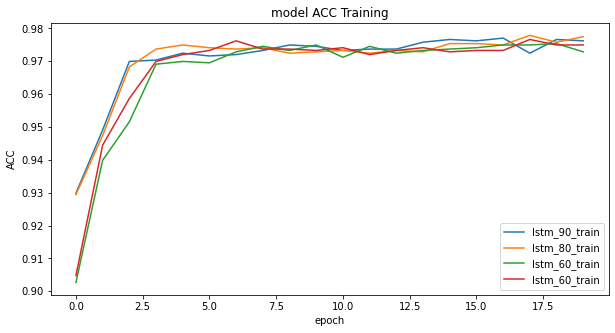

In [11]:
# with lagged 5 features

plt.figure(figsize=(10, 5))

plt.plot(history_90.history['accuracy'])
plt.plot(history_80.history['accuracy'])
plt.plot(history_60.history['accuracy'])
plt.plot(history_50.history['accuracy'])


plt.title('model ACC Training')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_train', 'lstm_80_train', 'lstm_60_train', 'lstm_60_train'], loc='lower right')
plt.show()

## 2 Layer LSTM model

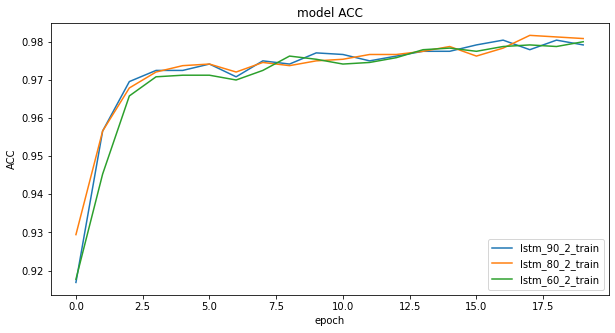

In [12]:
# with lagged 5 features

plt.figure(figsize=(10, 5))

plt.plot(history_90_2.history['accuracy'])
plt.plot(history_80_2.history['accuracy'])
plt.plot(history_60_2.history['accuracy'])

plt.title('model ACC')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_2_train', 'lstm_80_2_train', 'lstm_60_2_train'], loc='lower right')

plt.show()

## Locate the pandemic hub (one)

In [14]:
# modify HRUID
df_feature, df_label, df_hr1 = df_filter('2406', True,5)
X_train, X_test, y_train, y_test = train_test_split(
                     df_feature, df_label, test_size=0.2, random_state=42, shuffle=False)

Y_train = y_train.to_numpy().reshape(-1,)
Y_test = y_test.to_numpy().reshape(-1,)

n_sample = 1
n_step = X_train.shape[0]
n_features = X_train.shape[-1]
x_train = X_train.to_numpy().reshape(n_step, -1,n_features)
x_test = X_test.to_numpy().reshape(X_test.shape[0], -1,X_test.shape[-1])

train_pred_90 = model_90.predict_classes(x_train).flatten()
test_pred_90 = model_90.predict_classes(x_test).flatten()

print('ACC score on train:', accuracy_score(train_pred_90, Y_train))
print('ACC score on test:', accuracy_score(test_pred_90, Y_test))


ACC score on train: 0.9924812030075187
ACC score on test: 1.0


## HR: Quebec Health Unit
### Label Cumulative Cases
- PRUID_x = 24

In [19]:
history_90, model_90 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 90)
history_80, model_80 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 80)
history_60, model_60 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 60)
history_50, model_50 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 50)
history_90_2, model_90_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 90)
history_80_2, model_80_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 80)
history_60_2, model_60_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 60)

Train on 2394 samples, validate on 612 samples
Epoch 1/20
 - 5s - loss: 0.3527 - accuracy: 0.9215 - val_loss: 0.3075 - val_accuracy: 0.8889
Epoch 2/20
 - 1s - loss: 0.1278 - accuracy: 0.9457 - val_loss: 0.1617 - val_accuracy: 0.8889
Epoch 3/20
 - 2s - loss: 0.0659 - accuracy: 0.9724 - val_loss: 0.0755 - val_accuracy: 0.9444
Epoch 4/20
 - 1s - loss: 0.0366 - accuracy: 0.9908 - val_loss: 0.0451 - val_accuracy: 0.9984
Epoch 5/20
 - 1s - loss: 0.0257 - accuracy: 0.9971 - val_loss: 0.0322 - val_accuracy: 1.0000
Epoch 6/20
 - 1s - loss: 0.0199 - accuracy: 0.9975 - val_loss: 0.0207 - val_accuracy: 1.0000
Epoch 7/20
 - 1s - loss: 0.0166 - accuracy: 0.9954 - val_loss: 0.0199 - val_accuracy: 1.0000
Epoch 8/20
 - 1s - loss: 0.0147 - accuracy: 0.9967 - val_loss: 0.0165 - val_accuracy: 1.0000
Epoch 9/20
 - 1s - loss: 0.0129 - accuracy: 0.9962 - val_loss: 0.0189 - val_accuracy: 1.0000
Epoch 10/20
 - 1s - loss: 0.0117 - accuracy: 0.9967 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 11/20
 - 1s - lo

## 1 Layer LSTM model

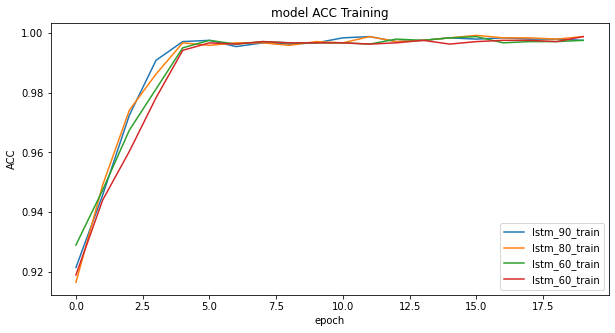

In [20]:
# with lagged 5 features

plt.figure(figsize=(10, 5))

plt.plot(history_90.history['accuracy'])
plt.plot(history_80.history['accuracy'])
plt.plot(history_60.history['accuracy'])
plt.plot(history_50.history['accuracy'])


plt.title('model ACC Training')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_train', 'lstm_80_train', 'lstm_60_train', 'lstm_60_train'], loc='lower right')
plt.show()

## 2 Layer LSTM model

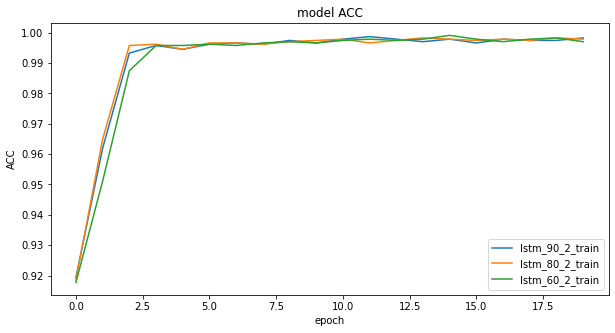

In [21]:
# with lagged 5 features

plt.figure(figsize=(10, 5))

plt.plot(history_90_2.history['accuracy'])
plt.plot(history_80_2.history['accuracy'])
plt.plot(history_60_2.history['accuracy'])

plt.title('model ACC')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_2_train', 'lstm_80_2_train', 'lstm_60_2_train'], loc='lower right')

plt.show()

## Locate the pandemic hub (one)

In [23]:
df_feature, df_label, df_hr1 = df_filter('2406', True,5)
X_train, X_test, y_train, y_test = train_test_split(
                     df_feature, df_label, test_size=0.2, random_state=42, shuffle=False)

Y_train = y_train.to_numpy().reshape(-1,)
Y_test = y_test.to_numpy().reshape(-1,)

n_sample = 1
n_step = X_train.shape[0]
n_features = X_train.shape[-1]
x_train = X_train.to_numpy().reshape(n_step, -1,n_features)
x_test = X_test.to_numpy().reshape(X_test.shape[0], -1,X_test.shape[-1])

train_pred_90 = model_90.predict_classes(x_train).flatten()
test_pred_90 = model_90.predict_classes(x_test).flatten()

print('ACC score on train:', accuracy_score(train_pred_90, Y_train))
print('ACC score on test:', accuracy_score(test_pred_90, Y_test))


ACC score on train: 0.9924812030075187
ACC score on test: 1.0
